In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from numba import njit,prange
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle




In [73]:
%%capture
%run  letters_extraction.ipynb

In [74]:
directory = './symbols/'

<h3>Reading directory names</h3>

In [75]:
Name=[]
for file in os.listdir(directory):
    Name+=[file]
print(Name)
print(len(Name))

['!', '(', ')', '+', '0', '1', '=', 'A', 'B', 'C', 'F', 'M', 'N', 'z']
14


<h4>Getting a list of unique file extensions</h4>

In [76]:
extensions = []

for path, subdirs, files in os.walk(directory):
        for name in files:
            if os.path.splitext(name)[1] not in extensions:
                extensions += [os.path.splitext(name)[1]]

print(extensions)
sorted(os.listdir(directory))

['.jpg', '.png', '.jpeg']


['!', '(', ')', '+', '0', '1', '=', 'A', 'B', 'C', 'F', 'M', 'N', 'z']

<h3>Map unique strings to integers in Python. Make dictionary</h3>

In [77]:
from collections import defaultdict
d = defaultdict(int)
co = 0
for x in sorted(os.listdir(directory)):
    if not d[x]:
        d[x] = co
        co+=1
d

defaultdict(int,
            {'!': 0,
             '(': 1,
             ')': 2,
             '+': 3,
             '0': 4,
             '1': 5,
             '=': 6,
             'A': 7,
             'B': 8,
             'C': 9,
             'F': 10,
             'M': 11,
             'N': 12,
             'z': 13})

<h3>Resizing images</h3>

In [78]:
from skimage.morphology import skeletonize
def prepare_image(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image = get_letters(image, single_letter=True)[0]
    return image

def images_resize(directory):
    list_target_names = []
    list_images = []
        
    for path, subdirs, files in os.walk(directory):
        files = [f for f in files if not f[0] == '.'] # Ignore '.directory' file
        # subdirs[:] = [d for d in subdirs if not d[0] == '.'] # Ignore hidden directories
        print(path, len(files))
        limit = 300
        if len(files) > limit:
            files = files[:limit]
            
        for name in files:
            image=cv2.imread(os.path.join(path, name))
            image = prepare_image(image)
            # image=cv2.resize(image, (100, 100))
            list_target_names.append(os.path.basename(path))
            list_images.append(image)
    
    return list_target_names,  list_images 
        
target_names,images = images_resize(directory)

./symbols/ 0
./symbols/! 1300
./symbols/( 14294
./symbols/) 14355
./symbols/+ 25112
./symbols/0 7509
./symbols/1 27082
./symbols/= 1397
./symbols/A 2455
./symbols/B 2400
./symbols/C 5857
./symbols/F 3767
./symbols/M 2476
./symbols/N 10862
./symbols/z 5870


In [79]:
len(target_names)

4200

In [80]:
len(images)

4200

In [81]:
from collections import Counter
c = Counter(sorted(target_names))

c

Counter({'!': 300,
         '(': 300,
         ')': 300,
         '+': 300,
         '0': 300,
         '1': 300,
         '=': 300,
         'A': 300,
         'B': 300,
         'C': 300,
         'F': 300,
         'M': 300,
         'N': 300,
         'z': 300})

<h3>Assign a Dictionary Value to the List <B><I>"target_names"</I></B> Based on Dictionary Key</h3>

In [82]:
target_names = [d[key] for key in target_names]

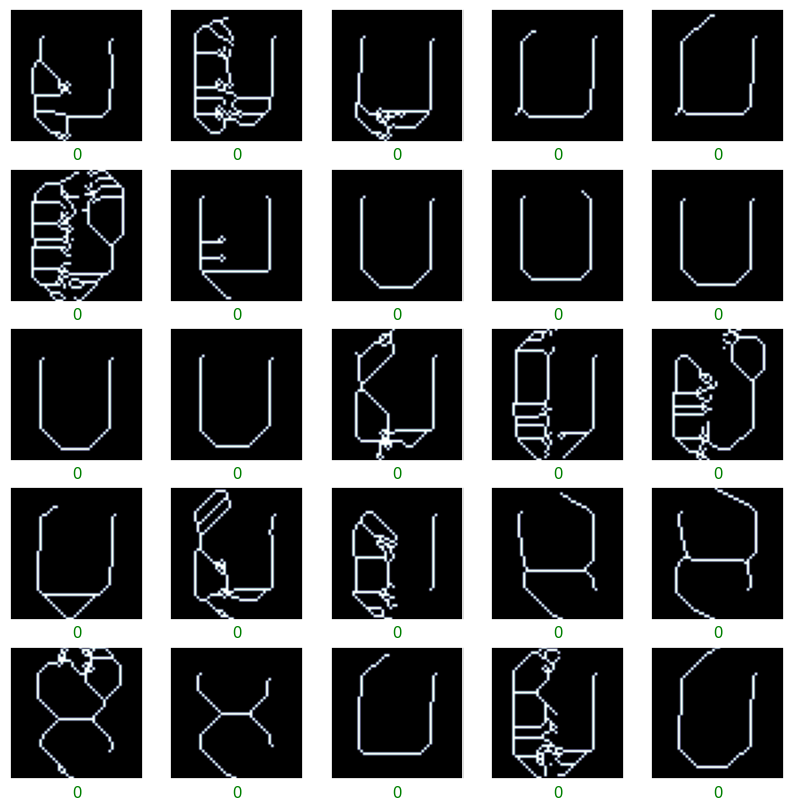

In [83]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=target_names[i])
    axi.xaxis.label.set_color('green')

<h4>Randomly shuffle two lists "target_names" and "images" keeping initial order</h4>

In [84]:
# target_names_shuffled, images_shuffled = shuffle(np.array(target_names, dtype=object), np.array(images, dtype=object))
target_names_shuffled, images_shuffled = shuffle(np.array(target_names), np.array(images))

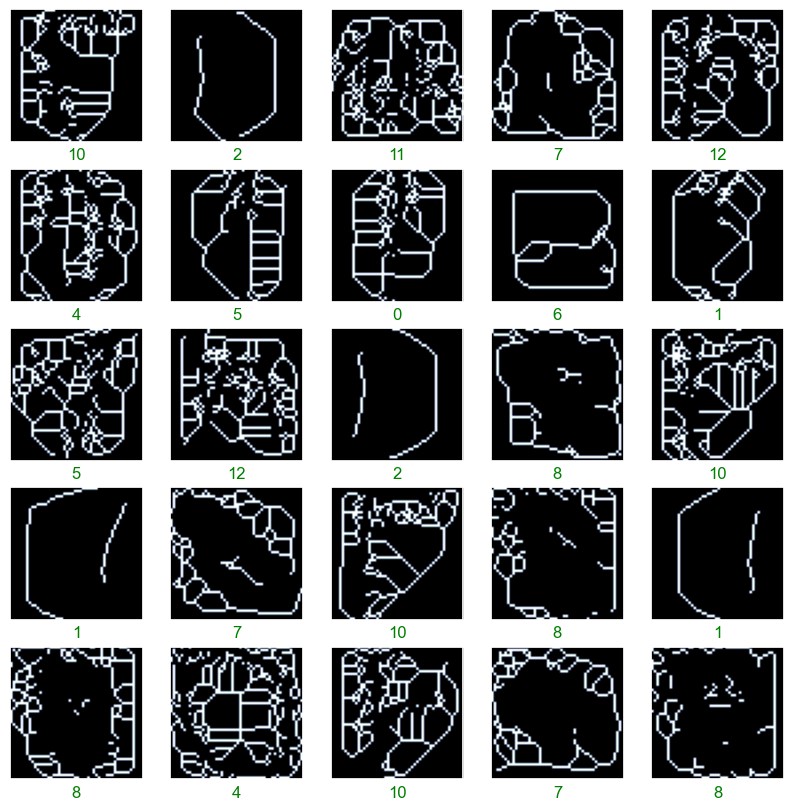

In [85]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(images_shuffled[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=target_names_shuffled[i])
    axi.xaxis.label.set_color('green')

<h4>Reshaping dataframe</h4>

In [86]:
n_samples,nx,ny= images_shuffled.shape
images_shuffled = images_shuffled.reshape(n_samples, nx*ny)
images_shuffled.shape

(4200, 2500)

In [87]:
Xtrain, Xtest, ytrain, ytest = train_test_split(images_shuffled, target_names_shuffled, random_state=0)

In [88]:
# import numpy as np
# from joblib import parallel_backend # added line.
# from sklearn.datasets import load_digits
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.svm import SVC      
# from sklearn.ensemble import RandomForestClassifier
# from ray.util.joblib import register_ray # added line.
# register_ray() # added line.

# param_space = {
#     'C': np.logspace(-6, 6, 30),
#     'gamma': np.logspace(-8, 8, 30),
#     'tol': np.logspace(-4, -1, 30),
#     'class_weight': [None, 'balanced'],
# }

# model = RandomForestClassifier(n_estimators=1000)
# search = RandomizedSearchCV(model, param_space, cv=5, n_iter=300,verbose=1)
# # digits = load_digits()
# ray.init(address='auto')
# with parallel_backend('ray'): # added line.
#     search.fit(Xtrain, ytrain)
    
# ypred = search.predict(Xtest)


<h3>Implementing an Random Forest Classifier</h3>

In [89]:
# from sklearnex import patch_sklearn
import joblib
# patch_sklearn()

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier()
# clf.fit(Xtrain, ytrain)
# ypred = clf.predict(Xtest)
# from sklearn import svm
# model = svm.SVC(gamma = 0.001, C =100)
# model.fit(Xtrain, ytrain)
# ypred = model.predict(Xtest)

 
# import pickle
# s = pickle.dumps(model)


In [99]:
import joblib

# save the model to disk
filename = './saved_models/finalized_model.sav'
joblib.dump(model, filename)
 

['./saved_models/finalized_model.sav']

<h3>The classification report for this classifier:</h3>

In [91]:
from sklearn import metrics
print(Xtest.shape)
print(metrics.classification_report(ytest, ypred))
print("Accuracy:",metrics.accuracy_score(ytest, ypred))

(1050, 2500)
              precision    recall  f1-score   support

           0       0.79      0.85      0.82        75
           1       0.88      0.85      0.87        88
           2       0.84      0.94      0.88        78
           3       0.86      0.91      0.88        85
           4       0.67      0.72      0.69        61
           5       0.76      0.71      0.73        79
           6       0.86      0.92      0.89        84
           7       0.88      0.93      0.90        69
           8       0.93      0.93      0.93        69
           9       0.76      0.84      0.80        77
          10       0.96      0.88      0.92        78
          11       0.92      0.86      0.89        70
          12       0.73      0.58      0.65        71
          13       0.98      0.85      0.91        66

    accuracy                           0.84      1050
   macro avg       0.84      0.84      0.84      1050
weighted avg       0.84      0.84      0.84      1050

Accuracy: 0.

<h3>Plot the confusion matrix:</h3>

Text(273.99999999999994, 0.5, 'predicted label')

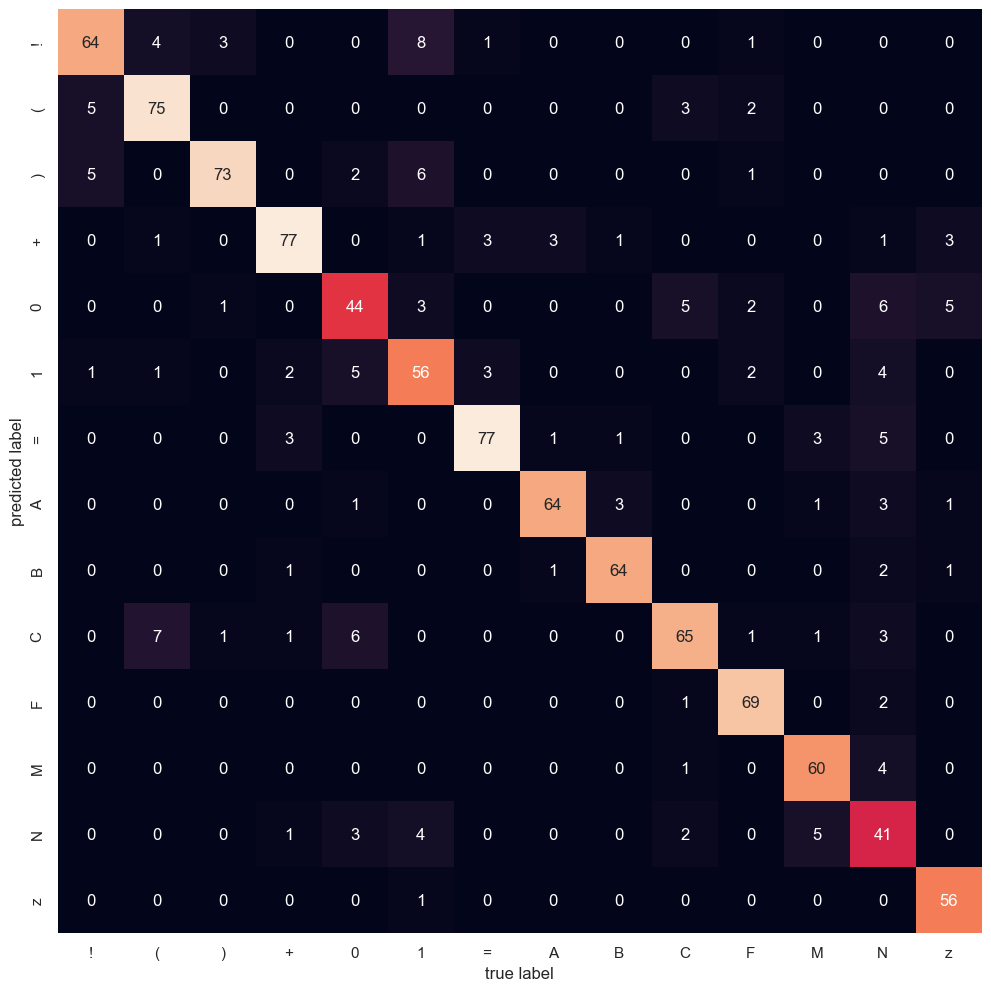

In [92]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,12)})

mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=list(d.keys()), yticklabels=list(d.keys()))


plt.xlabel('true label')
plt.ylabel('predicted label')


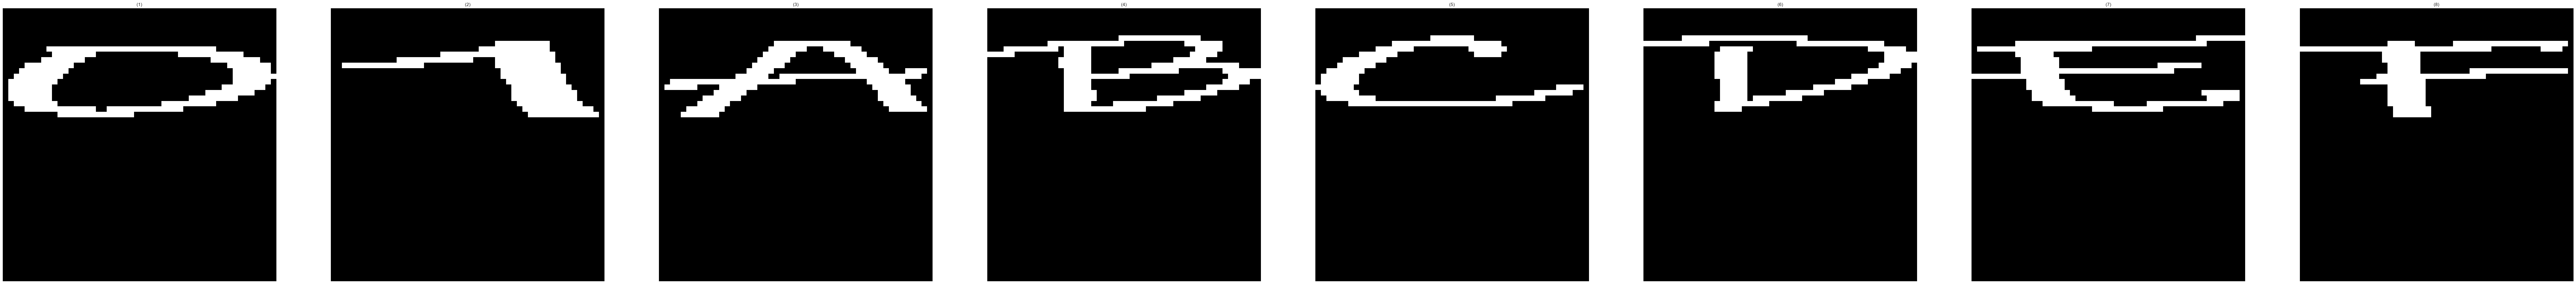

(8, 2500)
[6 6 6 6 6 3 3 3]
['=', '=', '=', '=', '=', '+', '+', '+']
['=', '=', '=', '=', '=', '+', '+', '+']


In [93]:
letters= cv2.cvtColor(cv2.imread(r'./test_images/classification/test1.png'), cv2.COLOR_BGR2GRAY)
letters_res = np.array(get_letters(letters, single_letter=False))
cf.show_images(letters_res)
# cf.show_images([letters_res[0], get_letters(letters, single_letter=False)[0]])

letters_res = letters_res.reshape(len(letters_res), -1)

print(letters_res.shape)

results = model.predict(letters_res)
print(results)
print([list(d.keys())[i] for i in results])
inv_map = {v: k for k, v in d.items()}
print([inv_map[i] for i in results])


In [94]:
# letters= cv2.cvtColor(cv2.imread(r'D:\academic_material\third_year\imageProcessing\repos\LogIm\phase_1\datasets\symbol2\9\0ZGdgPTM.png'), cv2.COLOR_BGR2GRAY)
# letters_res = np.array(get_letters(letters, single_letter=True, show_trace=True))
# cf.show_images([letters_res[0], get_letters(letters, single_letter=False,show_trace=True)[0]])

In [95]:

# import os
# import cv2
# import numpy as np

# # invert and rotate all the images in the B directory 
# # to make them look like the images in the A directory
# def invert_and_rotate_images(path):
#     for filename in os.listdir(path):
#         img = cv2.imread(os.path.join(path,filename))
#         img = cv2.bitwise_not(img)
#         img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
#         cv2.imwrite(os.path.join(path+'/inv/',filename), img)

# invert_and_rotate_images(r"D:\academic_material\third_year\imageProcessing\repos\LogIm\phase_1\datasets\emnist\EMNIST\A")


In [102]:
import joblib

model = joblib.load('./saved_models/finalized_model.sav')

img shape: (45, 45), max=255, min=0,median=255.0 and type uint8


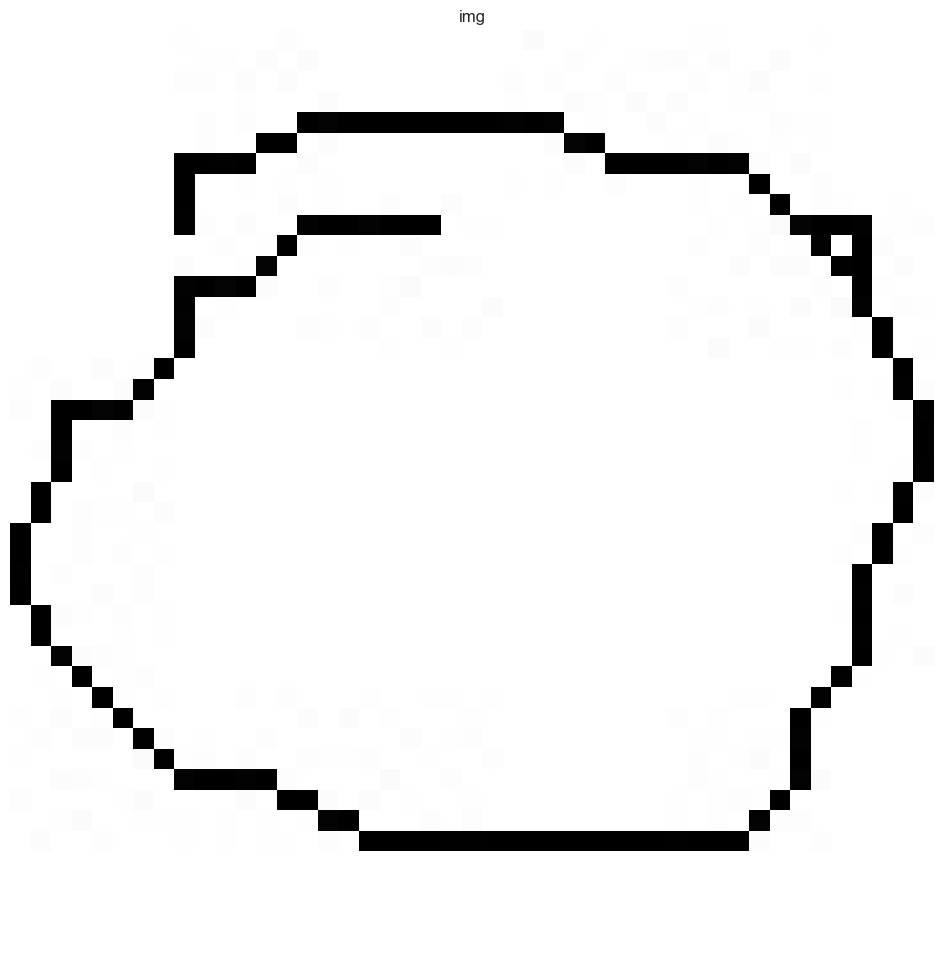

In [97]:
letters= cv2.cvtColor(cv2.imread(r'D:\academic_material\third_year\imageProcessing\repos\LogIm\phase_1\symbols\0\0_127.jpg'), cv2.COLOR_BGR2GRAY)
letters_res = np.array(get_letters(letters, single_letter=True, show_trace=True))






